In [1]:
using Pkg
Pkg.activate("/media/mat/HDD/EnKF/")

"/media/mat/HDD/EnKF/Project.toml"

In [4]:
using Revise
using EnKF
using Distributions
using DocStringExtensions
using LinearAlgebra
using Plots
using RecursiveArrayTools
using DifferentialEquations

We are interested in simulating the Lorenz attractor
            $$ ẋ = \sigma(y - x)\\
       ẏ = x(\rho-z) - y\\
       ż = xy - \beta z$$

Define parameters of the Lorenz attractor

In [101]:
function lorenz(du,u,p,t)
 du[1] = 10.0*(u[2]-u[1])
 du[2] = u[1]*(28.0-u[3]) - u[2]
 du[3] = u[1]*u[2] - (8/3)*u[3]
end

u0 = [1.0;0.0;0.0]
tspan = (0.0,1.0)
prob = ODEProblem(lorenz,u0,tspan)
sol = solve(prob)

Δt = 1e-3
T = tspan[1]:Δt:tspan[end]
integrator = init(prob, RK4(), adaptive =false, dt = Δt, save_everystep=false)

t: 0.0
u: 3-element Array{Float64,1}:
 1.0
 0.0
 0.0

In [102]:
states = [deepcopy(u0)]

1-element Array{Array{Float64,1},1}:
 [1.0, 0.0, 0.0]

In [103]:
for t in T[1:end-1]
    step!(integrator)
    push!(states, deepcopy(integrator.u))
end

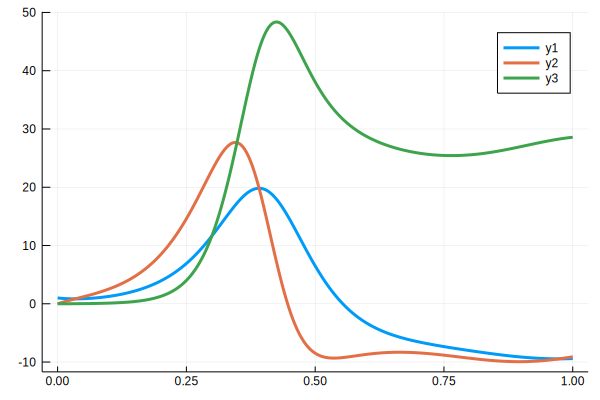

In [104]:
plot(T, hcat(states...)[1,:], linewidth  = 3)
plot!(T, hcat(states...)[2,:], linewidth = 3)
plot!(T, hcat(states...)[3,:], linewidth = 3)

Define propagation function fprop

In [147]:
function (::PropagationFunction)(t::Float64, ENS::EnsembleState{N, TS}) where {N, TS}
    for (i,s) in enumerate(ENS.S)
        set_t!(integrator, deepcopy(t))
        set_u!(integrator, deepcopy(s))
        step!(integrator)
        ENS.S[i] = deepcopy(integrator.u)

    end
    return ENS
end

In [148]:
fprop = PropagationFunction()

PropagationFunction()

Define measurement function m

In [150]:
function (::MeasurementFunction)(t::Float64, s::TS) where TS
    return s
end

In [151]:
function (::MeasurementFunction)(t::Float64)
    return I
end

In [152]:
m = MeasurementFunction()

MeasurementFunction()

Define  real measurement function z

In [153]:
Z = AdditiveInflation(MvNormal(zeros(3), 1e-3*I))

AdditiveInflation{3}(IsoNormal(
dim: 3
μ: [0.0, 0.0, 0.0]
Σ: [1.0e-6 0.0 0.0; 0.0 1.0e-6 0.0; 0.0 0.0 1.0e-6]
)
)

In [154]:
function (::RealMeasurementFunction)(t::Float64, ENS::EnsembleState{N, TZ}) where {N, TZ}
    return Z(ENS)
end

In [155]:
z = RealMeasurementFunction()

RealMeasurementFunction()

Define covariance inflation

In [172]:
A = MultiAdditiveInflation(3, 1.01, MvNormal(zeros(3), 1e-3*I))

MultiAdditiveInflation{3}(1.01, IsoNormal(
dim: 3
μ: [0.0, 0.0, 0.0]
Σ: [1.0e-6 0.0 0.0; 0.0 1.0e-6 0.0; 0.0 0.0 1.0e-6]
)
)

Define noise covariance

In [174]:
ϵ = AdditiveInflation(MvNormal(zeros(3), 1e-3*I))

AdditiveInflation{3}(IsoNormal(
dim: 3
μ: [0.0, 0.0, 0.0]
Σ: [1.0e-6 0.0 0.0; 0.0 1.0e-6 0.0; 0.0 0.0 1.0e-6]
)
)

In [175]:
N = 50
NZ = 3
isinflated = true
isfiltered = false
isaugmented = false

false

In [176]:
ens = initialize(N, MvNormal(u0, 1e-3*I))
estimation_state = [deepcopy(ens.S)]

tmp = deepcopy(u0)
true_state = [deepcopy(u0)]

1-element Array{Array{Float64,1},1}:
 [1.0, 0.0, 0.0]

In [177]:
ens

EnsembleState{50,Array{Float64,1}}(Array{Float64,1}[[0.999446, 0.000524588, -1.14963e-5], [0.999905, 0.000539296, 0.00131319], [0.999684, -0.000707178, -8.52798e-5], [1.00032, -0.000792392, -0.000791039], [1.00018, 0.00185544, -0.0019429], [1.0004, -0.00106071, 0.0017674], [0.999642, 0.000565225, 0.000143806], [1.00116, 0.000875015, 0.00189606], [1.00063, 0.000488858, -0.000250052], [1.00018, -0.000293417, 4.70888e-5]  …  [0.997125, 0.000467207, -0.00114974], [1.00211, -0.000493579, -0.000730452], [1.00024, -0.000585756, -0.00159969], [0.999025, -0.00100406, -0.000221715], [0.999946, 0.000489469, 0.00141273], [0.999253, -0.000229305, 0.00168159], [1.00058, -0.000164259, -0.0021994], [0.999401, 0.00128714, -0.000171904], [0.998553, -0.000779625, -0.000111636], [1.00202, 0.000806922, 0.000311317]])

In [178]:
g = FilteringFunction()

FilteringFunction()

In [179]:
enkf = ENKF(N, NZ, fprop, A, g, m, z, ϵ, isinflated, isfiltered, isaugmented)

ENKF{50,3}(PropagationFunction(), MultiAdditiveInflation{3}(1.01, IsoNormal(
dim: 3
μ: [0.0, 0.0, 0.0]
Σ: [1.0e-6 0.0 0.0; 0.0 1.0e-6 0.0; 0.0 0.0 1.0e-6]
)
), FilteringFunction(), MeasurementFunction(), RealMeasurementFunction(), AdditiveInflation{3}(IsoNormal(
dim: 3
μ: [0.0, 0.0, 0.0]
Σ: [1.0e-6 0.0 0.0; 0.0 1.0e-6 0.0; 0.0 0.0 1.0e-6]
)
), true, false, false)

### Ensemble Kalman filter estimation

In [180]:
Δt = 1e-3
T = 0.0:Δt:1.0

for (n,t) in enumerate(T)
    
#     push!(true_state, deepcopy(tmp))
    
    
    
    global ens
#     enkf.f(t, ens)
    t, ens = enkf(t, Δt, ens)
    
    push!(estimation_state, deepcopy(ens.S))
    

end

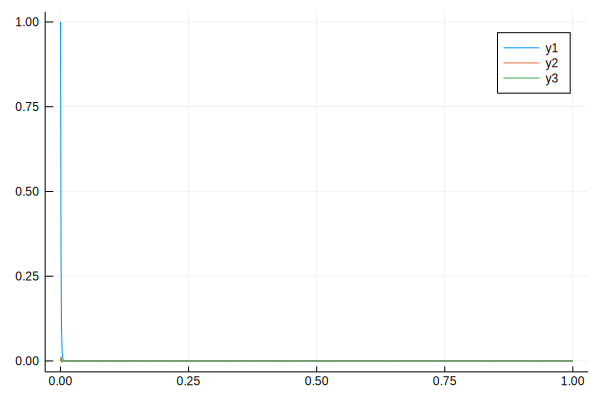

In [181]:
ŝ =  hcat(mean.(estimation_state)...)

plot(T,ŝ[1,1:end-1])
plot!(T,ŝ[2,1:end-1])
plot!(T,ŝ[3,1:end-1])


# s =  hcat(true_state...)
# plot!(sol, vars = (1))

In [ ]:
sol

In [71]:
sol.t

1287-element Array{Float64,1}:
   0.0                  
   3.5678604836301404e-5
   0.0003924646531993154
   0.0032624016752212923
   0.00905808176456279  
   0.0169564955927642   
   0.02769000245764448  
   0.04185634375662893  
   0.06024025665362463  
   0.0836852441654334   
   0.11336451506889586  
   0.14862131186030308  
   0.18703929175446188  
   ⋮                    
  99.17448947475748     
  99.25177886977121     
  99.3340481055892      
  99.40002509604705     
  99.47321520444633     
  99.54429913558833     
  99.6304176475736      
  99.73556893651245     
  99.81512588011671     
  99.88533419341042     
  99.94751447208056     
 100.0                  

In [69]:
collect(T)

1001-element Array{Float64,1}:
 0.0  
 0.001
 0.002
 0.003
 0.004
 0.005
 0.006
 0.007
 0.008
 0.009
 0.01 
 0.011
 0.012
 ⋮    
 0.989
 0.99 
 0.991
 0.992
 0.993
 0.994
 0.995
 0.996
 0.997
 0.998
 0.999
 1.0  